Dataset downloaded to: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1
Extracting to: /scratch/rameyjm7/RadDet
Found multipart archives: 21
Combined archives:
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/NISTSpecMaxHold128Data.tar.tar
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/NISTSpecMaxHold256Data.tar.tar
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/NISTSpecMaxHold512Data.tar.tar
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k128HW001Tv2.tar.tar
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k128HW009Tv2.tar.tar
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k256HW001Tv2.tar.tar
   /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k256HW009Tv2.tar.tar
   /home/rameyjm7/.cache/ka

/localscratch/124924/ipykernel_1511508/2851552397.py:76: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/NISTSpecMaxHold256Data.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/NISTSpecMaxHold512Data.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k128HW001Tv2.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k128HW009Tv2.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k256HW001Tv2.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k256HW009Tv2.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k512HW001Tv2.tar.tar
Extracting: /home/rameyjm7/.cache/kagglehub/datasets/abcxyzi/raddet-icassp-2025/versions/1/RadDet40k512HW009Tv2.tar.tar
Extraction complete.
Sample count: 3

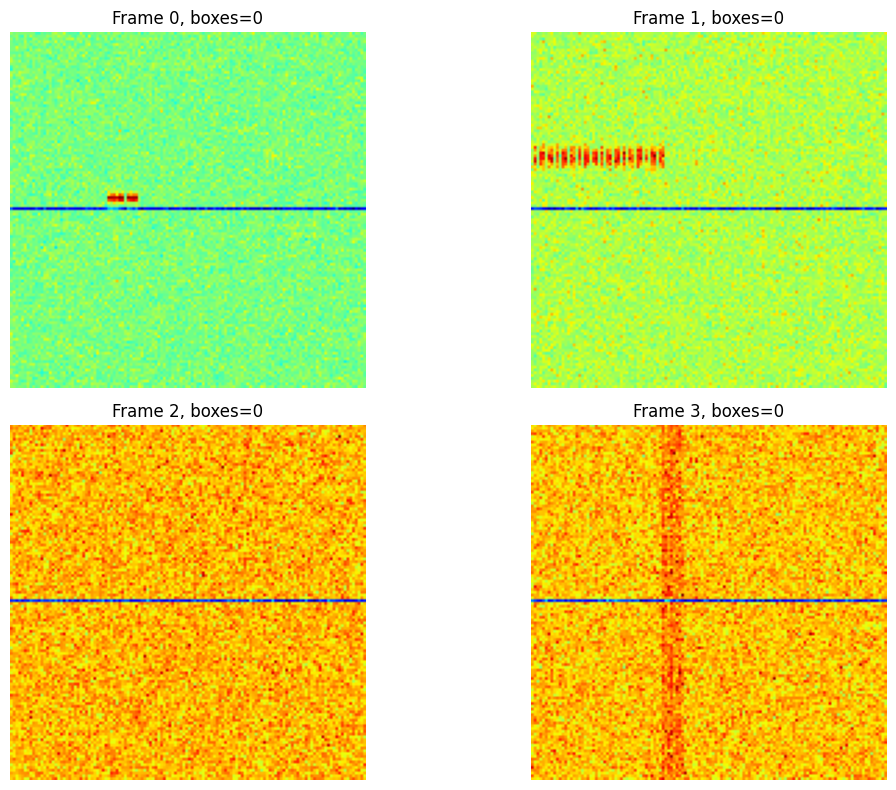

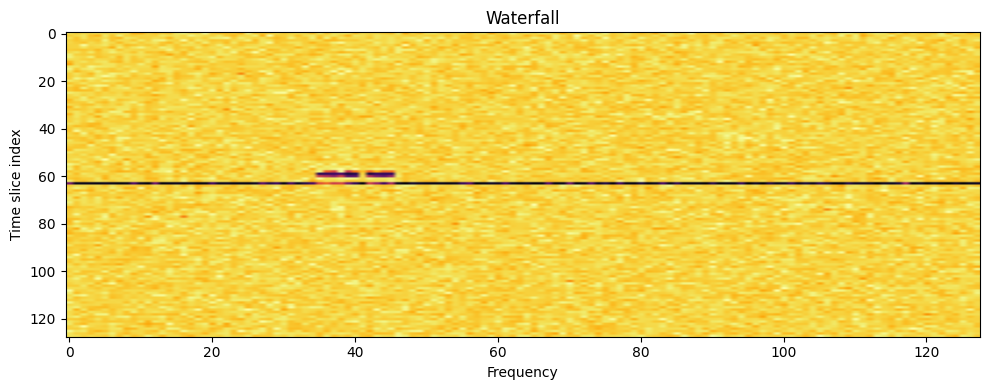

In [2]:
# ============================================================
# RadDet ICASSP 2025 Radar Spectrum Detection Dataset
# Cell 1: Download, extract, visualize, EDA
# ============================================================

import os
import tarfile
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import kagglehub

# ------------------------------------------------------------
# Step 1: Download Kaggle dataset
# ------------------------------------------------------------
print("Downloading RadDet dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("abcxyzi/raddet-icassp-2025")
print("Dataset downloaded to:", dataset_path)

# Directory where we will extract the final dataset
extract_dir = "/scratch/rameyjm7/RadDet"
os.makedirs(extract_dir, exist_ok=True)

print("Extracting to:", extract_dir)

# ------------------------------------------------------------
# Step 2: Find all multi-part TAR files
# ------------------------------------------------------------
parts = sorted(glob.glob(os.path.join(dataset_path, "*.part-*")))
print("Found multipart archives:", len(parts))

# ------------------------------------------------------------
# Step 3: Auto-recombine all multi-part tar files
# ------------------------------------------------------------

def recombine_tar(prefix):
    """Recombine all .part-* for a given prefix.tar.part-*"""
    part_files = sorted(glob.glob(os.path.join(dataset_path, prefix + ".part-*")))
    if not part_files:
        return None

    combined = os.path.join(dataset_path, prefix + ".tar")
    if os.path.exists(combined):
        return combined

    print(f"Recombining: {prefix}")
    with open(combined, "wb") as outfile:
        for p in part_files:
            with open(p, "rb") as infile:
                outfile.write(infile.read())
    return combined

# Detect all unique prefixes
unique_prefixes = sorted(
    set(os.path.basename(p).split(".part-")[0] for p in parts)
)

combined_archives = []
for prefix in unique_prefixes:
    t = recombine_tar(prefix)
    if t is not None:
        combined_archives.append(t)

print("Combined archives:")
for a in combined_archives:
    print("  ", a)

# ------------------------------------------------------------
# Step 4: Extract each TAR archive into /scratch/rameyjm7/RadDet
# ------------------------------------------------------------
for t in combined_archives:
    print("Extracting:", t)
    with tarfile.open(t, "r") as tar:
        tar.extractall(extract_dir)

print("Extraction complete.")

# ------------------------------------------------------------
# Step 5: EDA – collect images
# ------------------------------------------------------------
pngs = sorted(glob.glob(os.path.join(extract_dir, "**", "*.png"), recursive=True))
txts = [p.replace(".png", ".txt") for p in pngs]

print("Sample count:", len(pngs))

def load_yolo_bboxes(label_file):
    """Load YOLO (class cx cy w h) format."""
    if not os.path.exists(label_file):
        return []
    boxes = []
    with open(label_file, "r") as f:
        for line in f:
            vals = line.strip().split()
            cls = int(vals[0])
            cx, cy, w, h = map(float, vals[1:])
            boxes.append((cls, cx, cy, w, h))
    return boxes

def draw_boxes(im, bboxes, color=(255,0,0)):
    """Draw YOLO-format boxes on image."""
    h, w = im.shape[:2]
    overlay = im.copy()
    for cls, cx, cy, bw, bh in bboxes:
        x1 = int((cx - bw/2) * w)
        y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w)
        y2 = int((cy + bh/2) * h)
        cv2.rectangle(overlay, (x1,y1), (x2,y2), color, 1)
    return overlay

# ------------------------------------------------------------
# EDA Visualizations
# ------------------------------------------------------------
n_show = 4
plt.figure(figsize=(12, 8))

for i in range(n_show):
    img_path = pngs[i]
    lbl_path = txts[i]
    im = np.array(Image.open(img_path).convert("RGB"))
    bboxes = load_yolo_bboxes(lbl_path)
    im2 = draw_boxes(im, bboxes)

    plt.subplot(2, 2, i+1)
    plt.imshow(im2)
    plt.title(f"Frame {i}, boxes={len(bboxes)}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Step 6: Waterfall view
# ------------------------------------------------------------

def waterfall_view(im, slices=64):
    h, w = im.shape[:2]
    slice_h = h // slices
    wf = [im[i*slice_h:(i+1)*slice_h, :].mean(axis=0) for i in range(slices)]
    return np.array(wf)

sample = np.array(Image.open(pngs[0]).convert("L"))
wf = waterfall_view(sample, slices=128)

plt.figure(figsize=(10, 4))
plt.imshow(wf, aspect="auto", cmap="inferno")
plt.title("Waterfall")
plt.xlabel("Frequency")
plt.ylabel("Time slice index")
plt.tight_layout()
plt.show()


In [1]:
# --- Load CUDA module (if on HPC) ---
!module load CUDA/12.6.0

# --- Persist environment variables for this Python process ---
import os

os.environ["CUDA_HOME"] = "/apps/common/software/CUDA/12.6.0"
os.environ["PATH"] = f"{os.environ['CUDA_HOME']}/bin:" + os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CUDA_HOME']}/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

# --- Verify ---
!which nvcc
!nvidia-smi
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

/apps/common/software/CUDA/12.6.0/bin/nvcc
Fri Nov 21 23:48:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0             24W /  250W |       4MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+----

2025-11-21 23:48:28.612961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ============================================================
# WORKING YOLO TRAINING FOR RADDET / NIST
# ============================================================

import ultralytics
from ultralytics import YOLO
import os

# Force YOLO to use the scratch directory so it doesn't look in ~/.config/Ultralytics
ultralytics.settings.update({"datasets_dir": "/scratch/rameyjm7/RadDet"})

# Your dataset YAML (must contain absolute paths)
data_yaml = "/scratch/rameyjm7/RadDet/NISTSpecMaxHold128Data/data.yaml"
print("Using dataset:", data_yaml)

# ------------------------------------------------------------
# Load a SMALL YOLO model (fast + stable)
# ------------------------------------------------------------
model = YOLO("yolov8s.pt")    # small model

# ------------------------------------------------------------
# Train (simple, stable)
# ------------------------------------------------------------
results = model.train(
    data=data_yaml,
    imgsz=128,
    epochs=50,
    batch=32,
    workers=8,
    device=0,
    project="/scratch/rameyjm7/RadDet/runs",
    name="yolo_nist128_s",
)

# ------------------------------------------------------------
# Evaluate
# ------------------------------------------------------------
metrics = model.val()
print(metrics)

# ------------------------------------------------------------
# Export
# ------------------------------------------------------------
model.export(format="onnx")


Using dataset: /scratch/rameyjm7/RadDet/NISTSpecMaxHold128Data/data.yaml
New https://pypi.org/project/ultralytics/8.3.230 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.229 🚀 Python-3.12.8 torch-2.9.0+cu128 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/scratch/rameyjm7/RadDet/NISTSpecMaxHold128Data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=tra

'/scratch/rameyjm7/RadDet/runs/yolo_nist128_s3/weights/best.onnx'

Loaded class names: {0: 'P0N#1', 1: 'P0N#2', 2: 'Q3N#1', 3: 'Q3N#2', 4: 'Q3N#3'}
Model output: output0


/localscratch/126409/ipykernel_3048901/930388027.py:62: RuntimeWarning: overflow encountered in exp
  cls_probs = np.exp(cls_logits) / np.sum(np.exp(cls_logits), axis=1, keepdims=True)
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/localscratch/126409/ipykernel_3048901/930388027.py:62: RuntimeWarning: invalid value encountered in divide
  cls_probs = np.exp(cls_logits) / np.sum(np.exp(cls_logits), axis=1, keepdims=True)


Correct: 0
Incorrect: 6000

=== CORRECT PREDICTIONS ===

=== INCORRECT PREDICTIONS ===


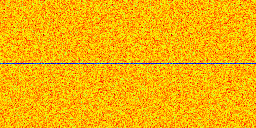

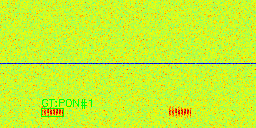

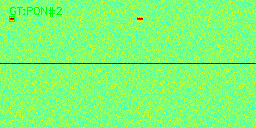

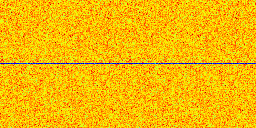

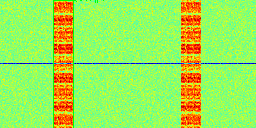

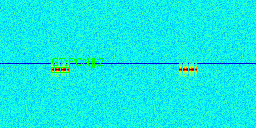

In [11]:
# ============================================================
# ONNX Detector Visualization: Correct vs Incorrect (YOLOv8+)
# ============================================================

import onnxruntime as ort
import cv2
import numpy as np
from IPython.display import display
from PIL import Image
import glob, os
import yaml

# --------------------------
# Paths
# --------------------------
model_path = "/scratch/rameyjm7/RadDet/runs/yolo_nist128_s3/weights/best.onnx"
root = "/scratch/rameyjm7/RadDet/NISTSpecMaxHold128Data"
val_imgs = sorted(glob.glob(os.path.join(root, "images/val/*.png")))

# --------------------------
# Load class names
# --------------------------
with open(os.path.join(root, "data.yaml")) as f:
    class_names = yaml.safe_load(f)["names"]

print("Loaded class names:", class_names)

# --------------------------
# ONNX session
# --------------------------
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
session = ort.InferenceSession(model_path, providers=providers)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print("Model output:", output_name)

# --------------------------
# Utility functions
# --------------------------
def preprocess(img):
    img = cv2.resize(img, (128,128))
    img = img[:, :, ::-1]       
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2,0,1))
    img = np.expand_dims(img, 0)
    return img

def xywh_to_xyxy(b):
    x,y,w,h = b
    return np.array([x-w/2, y-h/2, x+w/2, y+h/2])

def run_yolo_onnx(img):
    inp = preprocess(img)
    out = session.run([output_name], {input_name: inp})[0]  # shape (1, N, 10)
    out = out[0]

    boxes = out[:, 0:4]
    obj = out[:, 4:5]
    cls_logits = out[:, 5:]

    cls_probs = np.exp(cls_logits) / np.sum(np.exp(cls_logits), axis=1, keepdims=True)
    conf = obj * cls_probs.max(axis=1, keepdims=True)
    cls_ids = cls_probs.argmax(axis=1)

    valid = conf[:,0] > 0.25
    boxes = boxes[valid]
    conf = conf[valid][:,0]
    cls_ids = cls_ids[valid]

    preds = []
    for b, c, cls in zip(boxes, conf, cls_ids):
        x1,y1,x2,y2 = xywh_to_xyxy(b)
        preds.append([int(x1), int(y1), int(x2), int(y2), int(cls), float(c)])
    return preds

def load_gt(img_path):
    label = img_path.replace("images/val", "labels/val").replace(".png", ".txt")
    if not os.path.exists(label):
        return []
    gt = []
    for line in open(label):
        cls, cx, cy, w, h = map(float, line.split())
        cls = int(cls)
        x1,y1,x2,y2 = xywh_to_xyxy([cx*128, cy*128, w*128, h*128])
        gt.append([x1,y1,x2,y2,cls])
    return gt

def iou(a, b):
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    inter = max(0, xB-xA) * max(0, yB-yA)
    areaA = (a[2]-a[0])*(a[3]-a[1])
    areaB = (b[2]-b[0])*(b[3]-b[1])
    return inter / (areaA + areaB - inter + 1e-7)

def draw_boxes(img, boxes, color, prefix):
    for b in boxes:
        x1,y1,x2,y2,cls = map(int, b[:5])
        cv2.rectangle(img,(x1,y1),(x2,y2),color,1)
        cv2.putText(img, f"{prefix}:{class_names[cls]}",
                    (x1,max(0,y1-2)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,color,1)
    return img

# --------------------------
# Compare GT vs Predictions
# --------------------------
correct, incorrect = [], []

for img_path in val_imgs:
    img = cv2.imread(img_path)
    preds = run_yolo_onnx(img)
    gts = load_gt(img_path)

    matched = False
    for p in preds:
        for g in gts:
            if p[4] == g[4] and iou(p, g) >= 0.5:
                matched = True

    if matched:
        correct.append((img_path, gts, preds))
    else:
        incorrect.append((img_path, gts, preds))

print("Correct:", len(correct))
print("Incorrect:", len(incorrect))

# --------------------------
# Display function
# --------------------------
def show_samples(samples, title, max_show=6):
    print("\n=== " + title + " ===")
    for img_path, gts, preds in samples[:max_show]:
        img = cv2.imread(img_path)
        g = draw_boxes(img.copy(), gts, (0,255,0), "GT")
        p = draw_boxes(img.copy(), preds, (255,0,0), "P")
        combined = np.hstack([g, p])
        display(Image.fromarray(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)))

show_samples(correct, "CORRECT PREDICTIONS")
show_samples(incorrect, "INCORRECT PREDICTIONS")
